In [1]:
import tensorflow as tf
import keras
import numpy as np
!pip install livelossplot --quiet # library to plot training logs
from livelossplot import PlotLossesKeras
"Keras", keras.__version__, "tf", tf.__version__

Using TensorFlow backend.


('Keras', '2.1.6', 'tf', '1.9.0')

In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

[]

## loading in data

doing a simple normalization of the data. since these are images, its pretty straightforward to use data augmentation too.

In [3]:
(x_train, y_train),(x_test, y_test) = keras.datasets.cifar10.load_data()

# simple norm
#x_train, x_test = x_train / 255.0, x_test / 255.0
#x_train.shape, x_test.shape, y_train.shape, y_test.shape

#z-score norm
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

170500096/170498071 [==============================] - 21s 0us/step


the things we need to build a NN model:

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

In [0]:
#data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    )
datagen.fit(x_train, augment=True)

In [0]:
def make_model(dropout=0):
  model = Sequential()

  model.add(Conv2D(32, (3, 3), padding='same', activation='relu', 
                   input_shape=(32, 32, 3)))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  if dropout > 0: model.add(Dropout(dropout))

  model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  if dropout > 0: model.add(Dropout(dropout))

  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.5))

  model.add(Dense(10, activation='softmax'))

  model.compile(optimizer='Adam',
               loss = 'sparse_categorical_crossentropy',
               metrics=['accuracy'])

  return model

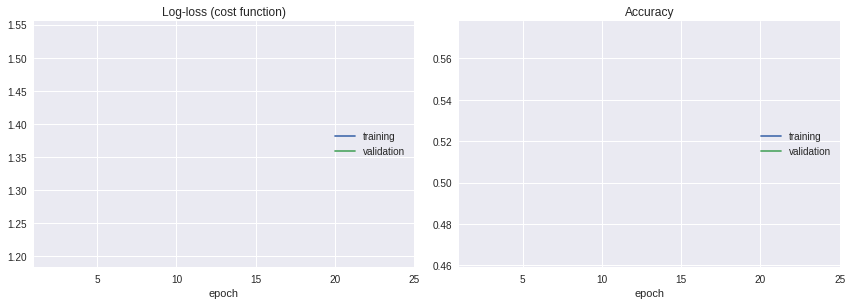

Epoch 2/25
 20/781 [..............................] - ETA: 8:58 - loss: 1.2219 - acc: 0.5805

KeyboardInterrupt: ignored

In [9]:
dropouts = np.arange(0, 0.6, 0.1)
history = []

for dropout in dropouts:
  model = make_model(dropout)
  
  hist = model.fit_generator(datagen.flow(x_train, y_train, batch_size=64), 
                    steps_per_epoch=len(x_train) / 64, 
                    epochs=25, validation_data=(x_test, y_test), 
                    callbacks=[PlotLossesKeras(), EarlyStopping(patience=4)])
  
  history.append(hist)

so now we have run the same model with different dropout numbers for the convulutional layers. so lets compare:

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

for dropout, hist in zip(dropouts, history):
  plt.plot(history.history['acc'], label=f"dropout_{dropout}", ls="dashed", lw=1, alpha=0.8)
  plt.plot(history.history['val_acc'], label=f"dropout_{dropout}", ls="solid", lw=2)
  
plt.show()

what beautiful graphs! especially compared to the version without dropout.

its quite clear from the losses and accuracy that adding dropout has an  important impact on the NN. in particular:

- with dropout, the model starts at a lower accuracy, but thats expected as there is less information passing through
- its no longer overfitting, so can train longer and get better results. I stopped it early but it can be tweaked to train longer.
- accuracy has increased, though not by much. 
- our simple model still starts overfitting, though later than before.

So dropout is a clear winner here, though of course it depends on the problem. there are a number of papers exploring effects of dropout on differrent problems. 
